In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [4]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [5]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [6]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:01,  9.57it/s]


(631520, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)

In [11]:
print(house_merge_df.shape)

(628988, 20)


In [12]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [14]:
target_gu = '마포구'
target_dong = '현석동'
target_purpose = '3종일반'
target_building_age = 5
target_period = 18 # in months

In [19]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    #&(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(148, 22)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
151121,서울특별시 마포구 현석동 108-24,토정로18길 15,(108-24),68.45,37.42,23000,1,1997.0,9.0,2006-10-26,336.011687,24.0,대,152.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151122,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,66.03,44.30,16900,4,1996.0,10.0,2006-05-13,255.944268,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151123,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,66.03,44.30,18300,4,1996.0,10.0,2006-07-11,277.146751,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151124,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,55.59,37.30,25000,1,1996.0,22.0,2018-01-22,449.721173,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151125,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,54.30,35.29,23000,5,2006.0,0.0,2006-06-12,423.572744,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동


In [20]:
target_df

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
151121,서울특별시 마포구 현석동 108-24,토정로18길 15,(108-24),68.45,37.42,23000,1,1997.0,9.0,2006-10-26,336.011687,24.0,대,152.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151122,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,66.03,44.30,16900,4,1996.0,10.0,2006-05-13,255.944268,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151123,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,66.03,44.30,18300,4,1996.0,10.0,2006-07-11,277.146751,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151124,서울특별시 마포구 현석동 159-1,신수로3길 3-9,가람빌라 다동,55.59,37.30,25000,1,1996.0,22.0,2018-01-22,449.721173,25.0,대,408.0,제2종일반주거지역,지정되지않음,다세대,완경사,부정형,세로한면(가),마포구,현석동
151125,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,54.30,35.29,23000,5,2006.0,0.0,2006-06-12,423.572744,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151126,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,53.30,34.64,23500,2,2006.0,0.0,2006-06-12,440.900563,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151127,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,63.65,40.20,25500,2,2006.0,0.0,2006-06-15,400.628437,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151128,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,54.30,35.29,27500,2,2006.0,0.0,2006-09-08,506.445672,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151129,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,55.49,36.06,28500,5,2006.0,0.0,2006-09-27,513.606055,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동
151130,서울특별시 마포구 현석동 105-54,토정로18길 14,수림파크빌,54.30,35.58,30000,3,2006.0,0.0,2006-10-27,552.486188,15.0,대,380.0,제3종일반주거지역,지정되지않음,주거나지,평지,부정형,중로각지,마포구,현석동


In [18]:
filenames = [os.listdir('./한국부동산원/실거래가격지수/')]
filenames

[['지역별_아파트_실거래가격지수_200601_202102.xlsx',
  '지역별_연립다세대_실거래가격지수_200601_202102.xlsx']]

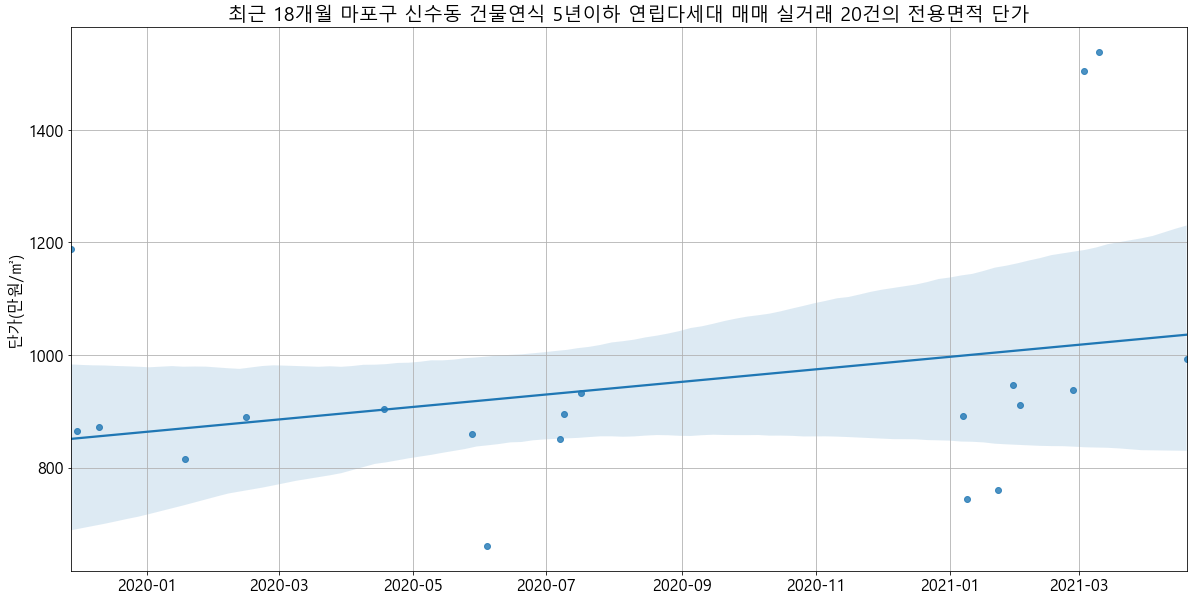

In [17]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house))

In [18]:
concat_df = pd.concat([target_df])

In [19]:
concat_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동
562699,서울특별시 마포구 신수동 250-16,대흥로9길 26,한강지오빌,39.36,26.30,26000,3,2016.0,4.0,2020-06-04,660.569106,5.0,대,291.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,마포구,신수동
582021,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,52.54,46.61,47500,5,2016.0,4.0,2020-04-18,904.073087,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동
582022,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,34.66,19.84,31000,4,2016.0,4.0,2020-07-09,894.402770,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동
582023,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,37.03,19.84,33000,2,2016.0,5.0,2021-01-07,891.169322,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동
582025,서울특별시 마포구 신수동 250-34,대흥로9길 14,만민하늘애A동,55.19,35.38,47000,4,2017.0,3.0,2020-07-07,851.603551,4.0,대,218.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,마포구,신수동


In [20]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']

In [21]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(20, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동,단가평균
0,서울특별시 마포구 신수동 250-16,대흥로9길 26,한강지오빌,39.36,26.30,26000,3,2016.0,4.0,2020-06-04,660.569106,5.0,대,291.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,마포구,신수동,660.569106
1,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,52.54,46.61,47500,5,2016.0,4.0,2020-04-18,904.073087,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,896.548393
2,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,34.66,19.84,31000,4,2016.0,4.0,2020-07-09,894.402770,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,896.548393
3,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,37.03,19.84,33000,2,2016.0,5.0,2021-01-07,891.169322,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,896.548393
4,서울특별시 마포구 신수동 250-33,대흥로9안길 4,만민하늘애B동,43.52,28.88,35500,4,2017.0,3.0,2020-01-18,815.716912,4.0,대,268.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,862.416311


In [22]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(10, 24)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,지형형상2,구,동,단가평균
0,서울특별시 마포구 신수동 250-16,대흥로9길 26,한강지오빌,39.36,26.30,26000,3,2016.0,4.0,2020-06-04,660.569106,5.0,대,291.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,마포구,신수동,660.569106
3,서울특별시 마포구 신수동 250-27,대흥로9안길 18,동양하우징,37.03,19.84,33000,2,2016.0,5.0,2021-01-07,891.169322,5.0,대,159.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,896.548393
6,서울특별시 마포구 신수동 250-33,대흥로9안길 4,만민하늘애B동,40.58,26.92,37000,5,2017.0,4.0,2021-02-02,911.779202,4.0,대,268.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),사다리형,마포구,신수동,862.416311
7,서울특별시 마포구 신수동 250-34,대흥로9길 14,만민하늘애A동,55.19,35.38,47000,4,2017.0,3.0,2020-07-07,851.603551,4.0,대,218.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),사다리형,마포구,신수동,851.603551
9,서울특별시 마포구 신수동 288-10,토정로15길 10-3,루체른,29.56,21.73,28000,3,2016.0,5.0,2021-01-30,947.225981,5.0,대,179.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(불),사다리형,마포구,신수동,940.030901
10,서울특별시 마포구 신수동 313-2,토정로15길 32-1,우정쉐르빌,28.43,17.70,33800,3,2019.0,0.0,2019-11-27,1188.884981,2.0,대,283.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로한면,사다리형,마포구,신수동,1188.884981
13,서울특별시 마포구 신수동 62-56,대흥로13길 17-3,라루체-1,29.85,20.63,28000,2,2016.0,5.0,2021-02-26,938.023451,5.0,대,232.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(불),사다리형,마포구,신수동,814.067784
16,서울특별시 마포구 신수동 62-60,대흥로13길 11-4,라루체-2,29.80,19.68,26500,5,2016.0,4.0,2020-02-15,889.261745,5.0,대,237.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(불),사다리형,마포구,신수동,875.699152
17,서울특별시 마포구 신수동 62-82,대흥로11안길 20,한신지우빌,29.91,18.52,29700,2,2018.0,3.0,2021-04-19,992.978937,3.0,대,152.0,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),장방형,마포구,신수동,992.978937
19,서울특별시 마포구 신수동 88-30,독막로31길 7-1,서강 퀸즈하우스,19.50,13.00,30000,4,2021.0,0.0,2021-03-10,1538.461538,0.0,대,216.0,제2종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),사다리형,마포구,신수동,1521.236117


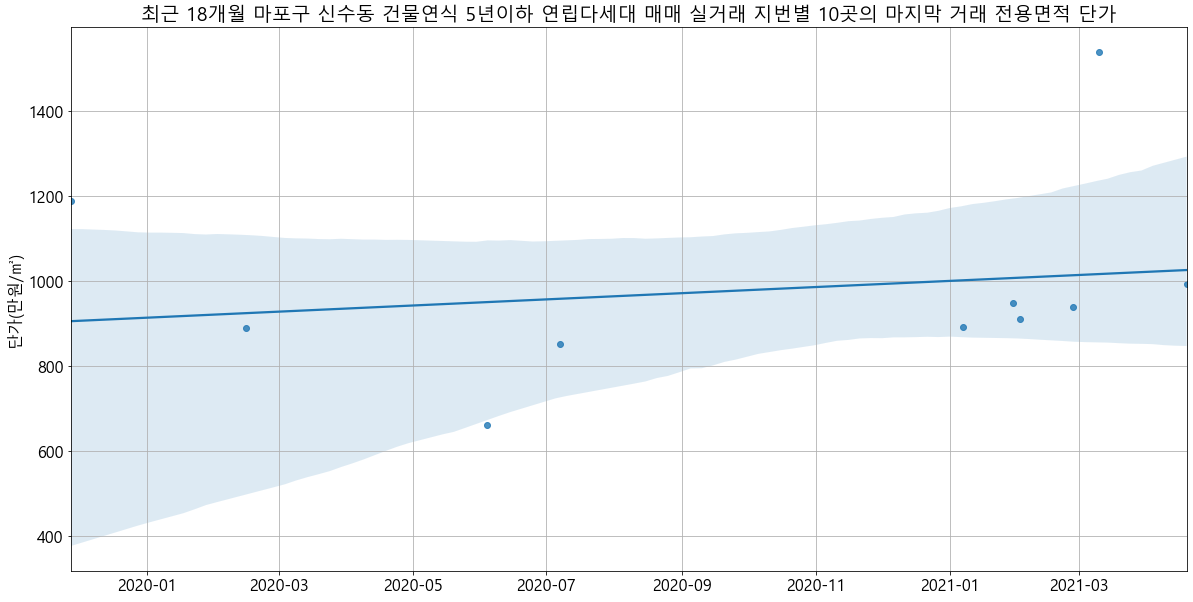

In [23]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(concat_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(concat_last_df['계약날짜']), y=concat_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_산포도.png'.format(target_gu, target_dong, target_house))

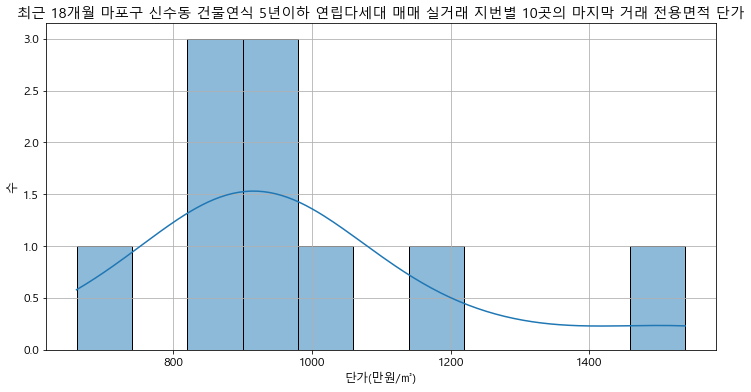

<Figure size 432x288 with 0 Axes>

In [24]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.grid(True)
plt.ylabel('수')
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 마지막 거래 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
sns.histplot(concat_last_df['단가(만원/㎡)'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house))
plt.show()
plt.clf()

In [25]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [26]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가(만원/㎡)', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가(만원/㎡),용도지역명1
0,서울특별시 마포구 신수동 250-16,한강지오빌,2016.0,2020-06-04,660.569106,제2종일반주거지역
1,서울특별시 마포구 신수동 250-27,동양하우징,2016.0,2021-01-07,891.169322,제2종일반주거지역
2,서울특별시 마포구 신수동 250-33,만민하늘애B동,2017.0,2021-02-02,911.779202,제2종일반주거지역
3,서울특별시 마포구 신수동 250-34,만민하늘애A동,2017.0,2020-07-07,851.603551,제2종일반주거지역
4,서울특별시 마포구 신수동 288-10,루체른,2016.0,2021-01-30,947.225981,제2종일반주거지역
5,서울특별시 마포구 신수동 313-2,우정쉐르빌,2019.0,2019-11-27,1188.884981,제2종일반주거지역
6,서울특별시 마포구 신수동 62-56,라루체-1,2016.0,2021-02-26,938.023451,제2종일반주거지역
7,서울특별시 마포구 신수동 62-60,라루체-2,2016.0,2020-02-15,889.261745,제2종일반주거지역
8,서울특별시 마포구 신수동 62-82,한신지우빌,2018.0,2021-04-19,992.978937,제2종일반주거지역
9,서울특별시 마포구 신수동 88-30,서강 퀸즈하우스,2021.0,2021-03-10,1538.461538,제2종일반주거지역


In [27]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house), index=False)